In [9]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm
import numpy_financial as npf
import requests

In [72]:
principal_usd = 1000000

def generate_df(file_name):
    df = pd.read_csv(f"./data/coincodex2/{file_name}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df = df.iloc[::-1]
    df = df[df.index >= datetime(2020,12,1)]
    df.head()
    return df

def calculate_allocation(index,allocation,coin,input_df):
    input_df[f'{coin}_ALLOC'] = allocation
    input_df[f'{coin}_NET_ALLOC_USD'] = (input_df[f'{coin}_ALLOC'] * principal_usd)  
    input_df[f'{coin}_INIT_AMNT'] = round(input_df[f'{coin}_NET_ALLOC_USD'] / float(input_df[f'{coin}'].iloc[0]),2)
    input_df[f'{coin}_AMNT'] = input_df[f'{coin}_INIT_AMNT']
    input_df[f'{coin}_NET'] = round(input_df[f'{coin}_INIT_AMNT'] * input_df[f'{coin}'],2)
    
def re_calculate_allocation(input_df,coin,allocation):
    input_df[f'{coin}_ALLOC'] = allocation
    input_df[f'{coin}_NET_ALLOC_USD'] = (input_df[f'{coin}_ALLOC'] * principal_usd)  
    input_df[f'{coin}_INIT_AMNT'] = round(input_df[f'{coin}_NET_ALLOC_USD'] / float(input_df[f'{coin}'].iloc[0]),2)
    input_df[f'{coin}_AMNT'] = input_df[f'{coin}_INIT_AMNT']
    input_df[f'{coin}_NET'] = round(input_df[f'{coin}_INIT_AMNT'] * input_df[f'{coin}'],2)

def add_day_count(input_df):
    input_df['NET'] = 0
    input_df['Day_Count'] = 1
    input_df['Day_Count_Cum'] = input_df['Day_Count'].cumsum()

def convert_yield_to_daily(annual_yield):
    ANNUAL_YIELD_PERCENTAGE = annual_yield / 100
    DAILY_YIELD_PERCENTAGE = (1 + ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
    return DAILY_YIELD_PERCENTAGE

def assign_daily_rate(coin,annual_yield,input_df):
    input_df[f'{coin}_Daily_Rate'] = convert_yield_to_daily(annual_yield)
    
def calculate_yield(annual_yield,input_df,coin):
    ANNUAL_YIELD_PERCENTAGE = annual_yield / 100
    DAILY_YIELD_PERCENTAGE = (1 + ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
    INITIAL_DAILY_YIELD_AMNT = input_df[f'{coin}_INIT_AMNT'] * DAILY_YIELD_PERCENTAGE
    input_df[f'{coin}_Daily_Rate'] = DAILY_YIELD_PERCENTAGE
    input_df[f'{coin}_AMNT_YIELD'] = input_df[f'{coin}_AMNT'] * (1 + DAILY_YIELD_PERCENTAGE) ** (input_df['Day_Count_Cum'])
    input_df[f'{coin}_NET_YIELD'] = round(input_df[f'{coin}_AMNT_YIELD'] * input_df[f"{coin}"],2)

def re_calculate_yield(input_df,coin):
    input_df[f'{coin}_AMNT_YIELD'] = input_df[f'{coin}_AMNT'] * (1 + input_df[f'{coin}_Daily_Rate']) ** (input_df['Day_Count_Cum'])
    input_df[f'{coin}_NET_YIELD'] = round(input_df[f'{coin}_AMNT_YIELD'] * input_df[f"{coin}"],2)
    
def plot_df(input_df,title,columns=[]):
    pl = input_df.plot(y=columns,figsize=(16,8),title=title)
    # after plotting the data, format the labels
    current_values = pl.get_yticks()
    # using format string '{:.0f}' here but you can choose others
    pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);


In [73]:
btc_df = generate_df("bitcoin_2020-12-1_2022-5-10.csv")
eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
bnb_df = generate_df("binance-coin_2020-12-1_2022-5-10.csv")
xrp_df = generate_df("ripple_2020-12-1_2022-5-10.csv")
ada_df = generate_df("cardano_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-10.csv")
dot_df = generate_df("polkadot_2020-12-1_2022-5-10.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-10 (1).csv")
matic_df = generate_df("matic-network_2020-12-1_2022-5-10.csv")
luna_df = generate_df("terra_2020-12-1_2022-5-10.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-10.csv")

In [84]:
eth_var_yield_portfolio_df = pd.concat([eth_df['Close']],axis=1)
eth_var_yield_portfolio_df.columns = ['ETH']
calculate_allocation(0,1,'ETH',eth_var_yield_portfolio_df)
eth_var_yield_portfolio_df.loc[(eth_var_yield_portfolio_df.index > datetime(2022,5,1)),'ETH_COIN_ALLOC'] = 0.5
#re_calculate_allocation(eth_var_yield_portfolio_df,"ETH",0.5)
add_day_count(eth_var_yield_portfolio_df)
calculate_yield(18.00,eth_var_yield_portfolio_df,'ETH')
eth_var_yield_portfolio_df.loc[(eth_var_yield_portfolio_df.index < datetime(2021,9,1)) & (eth_var_yield_portfolio_df.index >= datetime(2021,5,1)),'ETH_Daily_Rate'] = convert_yield_to_daily(15)
eth_var_yield_portfolio_df.loc[(eth_var_yield_portfolio_df.index < datetime(2022,1,1)) & (eth_var_yield_portfolio_df.index >= datetime(2021,9,1)),'ETH_Daily_Rate'] = convert_yield_to_daily(14)
eth_var_yield_portfolio_df.loc[(eth_var_yield_portfolio_df.index < datetime(2022,3,1)) & (eth_var_yield_portfolio_df.index >= datetime(2022,1,1)),'ETH_Daily_Rate'] = convert_yield_to_daily(13)
eth_var_yield_portfolio_df.loc[eth_var_yield_portfolio_df.index >= datetime(2022,3,1),'ETH_Daily_Rate'] = convert_yield_to_daily(12)
re_calculate_yield(eth_var_yield_portfolio_df,'ETH')
eth_var_yield_portfolio_df

,ETH,ETH_ALLOC,ETH_NET_ALLOC_USD,ETH_INIT_AMNT,ETH_AMNT,ETH_NET,ETH_COIN_ALLOC,NET,Day_Count,Day_Count_Cum,ETH_Daily_Rate,ETH_AMNT_YIELD,ETH_NET_YIELD
Date,,,,,,,,,,,,,
2020-12-01,589.814467,1,1000000,1695.45,1695.45,1000000.94,NaN,0,1,1,0.000454,1696.219000,1000454.51
2020-12-02,598.357253,1,1000000,1695.45,1695.45,1014484.81,NaN,0,1,2,0.000454,1696.988349,1015405.29
2020-12-03,616.904853,1,1000000,1695.45,1695.45,1045931.33,NaN,0,1,3,0.000454,1697.758047,1047355.18
2020-12-04,571.978333,1,1000000,1695.45,1695.45,969760.66,NaN,0,1,4,0.000454,1698.528094,971521.27
2020-12-05,595.548506,1,1000000,1695.45,1695.45,1009722.71,NaN,0,1,5,0.000454,1699.298491,1012014.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,1,1000000,1695.45,1695.45,4667540.62,0.5,0,1,521,0.000311,1993.143912,5487086.12
2022-05-06,2699.825200,1,1000000,1695.45,1695.45,4577418.64,0.5,0,1,522,0.000311,1993.762858,5382811.21
2022-05-07,2644.925800,1,1000000,1695.45,1695.45,4484339.45,0.5,0,1,523,0.000311,1994.381997,5274992.40


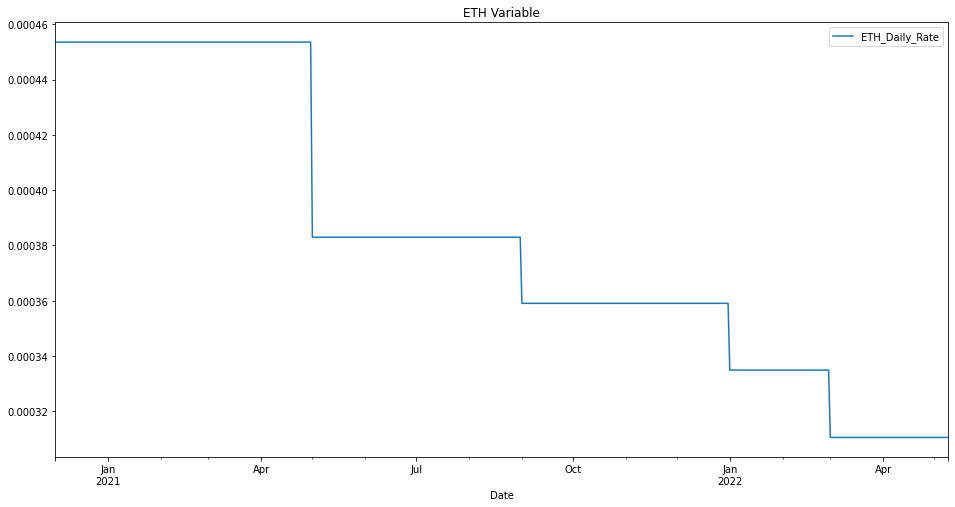

In [85]:
pl = eth_var_yield_portfolio_df.plot(y=["ETH_Daily_Rate"],figsize=(16,8),title="ETH Variable")

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


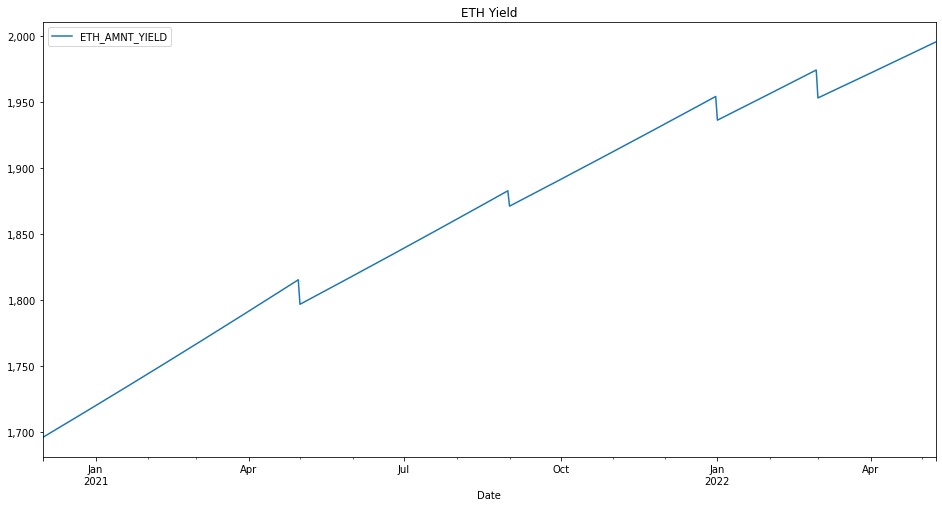

In [78]:
plot_df(eth_var_yield_portfolio_df,"ETH Yield",["ETH_AMNT_YIELD"])

In [5]:
# https://21shares.com/product/hodlx/
holdx_coins = ['BTC','ETH','BNB','XRP','ADA','SOL','DOT','AVAX','MATIC','LUNA']
holdx_allocation = [0.5824,0.2766,0.0472,0.0245,0.0214,0.0191,0.0105,0.0102,0.0068,0.0013]
sum(holdx_allocation)

0.9999999999999999

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":


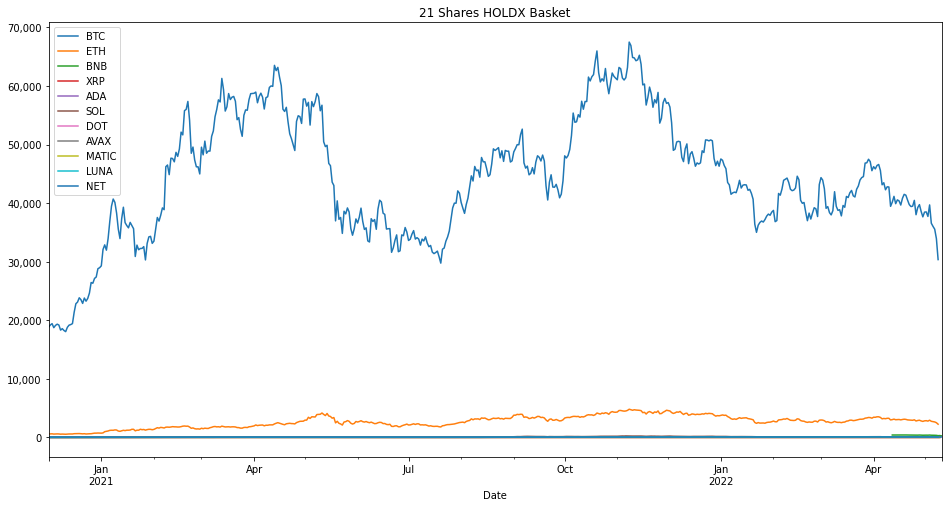

In [95]:
hodlx_portfolio_df = pd.concat([btc_df['Close'],eth_df['Close'], bnb_df['Close'], xrp_df['Close'],ada_df['Close'], sol_df['Close'],dot_df['Close'],avax_df['Close'],matic_df['Close'],luna_df['Close']],axis=1)
hodlx_portfolio_df.columns = holdx_coins
#hodlx_portfolio_df.fillna(0, inplace=True)
hodlx_portfolio_df['NET'] = 0
pl = hodlx_portfolio_df.plot(figsize=(16,8),title='21 Shares HOLDX Basket')
# after plotting the data, format the labels
current_values = pl.get_yticks()
# using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


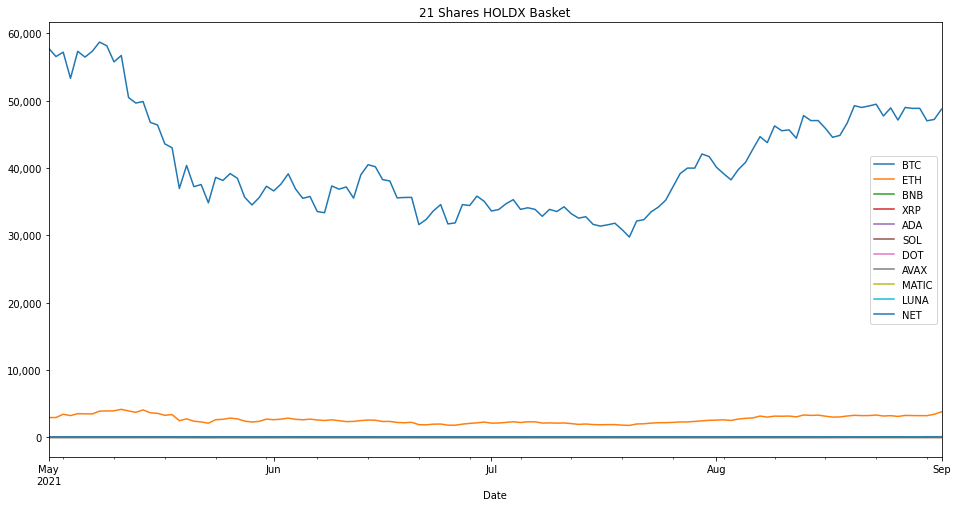

In [96]:
hodlx_portfolio_bear_df = hodlx_portfolio_df[(hodlx_portfolio_df.index >= datetime(2021,5,1)) & (hodlx_portfolio_df.index <= datetime(2021,9,1))]
pl = hodlx_portfolio_bear_df.plot(figsize=(16,8),title='21 Shares HOLDX Basket')
# after plotting the data, format the labels
current_values = pl.get_yticks()
# using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [159]:
hodlx_portfolio_bear_df['NET'] = 0.0
holdx_coins = ['BTC','ETH','BNB','XRP','ADA','SOL','DOT','AVAX','MATIC','LUNA']
for i in range(0,len(holdx_coins)):
    calculate_allocation(i,holdx_coins[i],hodlx_portfolio_df)


hodlx_portfolio_df['HOLDX_NET'] = hodlx_portfolio_df['BTC_NET'] + hodlx_portfolio_df['ETH_NET'] + hodlx_portfolio_df['AVAX_NET']  + hodlx_portfolio_df['SOL_NET'] + hodlx_portfolio_df['DOT_NET'] + hodlx_portfolio_df['XRP_NET'] + hodlx_portfolio_df['ADA_NET'] + hodlx_portfolio_df['MATIC_NET'] + hodlx_portfolio_df['LUNA_NET']
#+ hodlx_portfolio_df['BNB_NET'] + hodlx_portfolio_df['ADA_NET'] + hodlx_portfolio_df['SOL_NET'] + hodlx_portfolio_df['DOT_NET'] + hodlx_portfolio_df['AVAX_NET'] + hodlx_portfolio_bear_df['MATIC_NET'] + hodlx_portfolio_df['LUNA_NET']
hodlx_portfolio_df.fillna(0,inplace=True)
hodlx_portfolio_df

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,BTC,ETH,BNB,XRP,ADA,SOL,DOT,AVAX,MATIC,LUNA,...,MATIC_NET_ALLOC_USD,MATIC_INIT_AMNT,MATIC_AMNT,MATIC_NET,LUNA_ALLOC,LUNA_NET_ALLOC_USD,LUNA_INIT_AMNT,LUNA_AMNT,LUNA_NET,HOLDX_NET
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,18855.043740,589.814467,0.000000,0.614801,0.156136,1.977516,5.094680,3.576271,0.018725,0.388320,...,6800.0,363151.92,363151.92,6800.00,0.0013,1300.0,3347.76,3347.76,1300.00,952831.66
2020-12-02,19201.276131,598.357253,0.000000,0.630396,0.158604,2.112355,5.448876,3.745825,0.019348,0.406310,...,6800.0,363151.92,363151.92,7026.25,0.0013,1300.0,3347.76,3347.76,1360.23,971295.16
2020-12-03,19427.954960,616.904853,0.000000,0.631641,0.164295,2.098405,5.413367,3.819472,0.020795,0.506414,...,6800.0,363151.92,363151.92,7551.77,0.0013,1300.0,3347.76,3347.76,1695.35,988687.76
2020-12-04,18737.192660,571.978333,0.000000,0.559131,0.148866,1.856668,5.047263,3.556966,0.018869,0.451015,...,6800.0,363151.92,363151.92,6852.26,0.0013,1300.0,3347.76,3347.76,1509.89,936554.15
2020-12-05,19127.656824,595.548506,0.000000,0.583935,0.159815,1.977440,5.186312,3.630332,0.019663,0.509040,...,6800.0,363151.92,363151.92,7140.64,0.0013,1300.0,3347.76,3347.76,1704.15,964303.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-07,35552.564000,2644.925800,366.350500,0.582890,0.763898,79.132500,13.801500,55.330400,1.022821,68.488700,...,6800.0,363151.92,363151.92,371439.32,0.0013,1300.0,3347.76,3347.76,229283.73,4017796.23
2022-05-08,33933.542810,2513.908346,354.715770,0.564983,0.737345,74.977144,13.179436,51.193573,0.970389,63.512774,...,6800.0,363151.92,363151.92,352398.75,0.0013,1300.0,3347.76,3347.76,212625.52,3813075.29
2022-05-09,30363.865617,2258.003467,302.358236,0.496812,0.617137,63.959513,10.875685,42.411593,0.828005,34.115661,...,6800.0,363151.92,363151.92,300691.60,0.0013,1300.0,3347.76,3347.76,114211.04,3277274.82


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


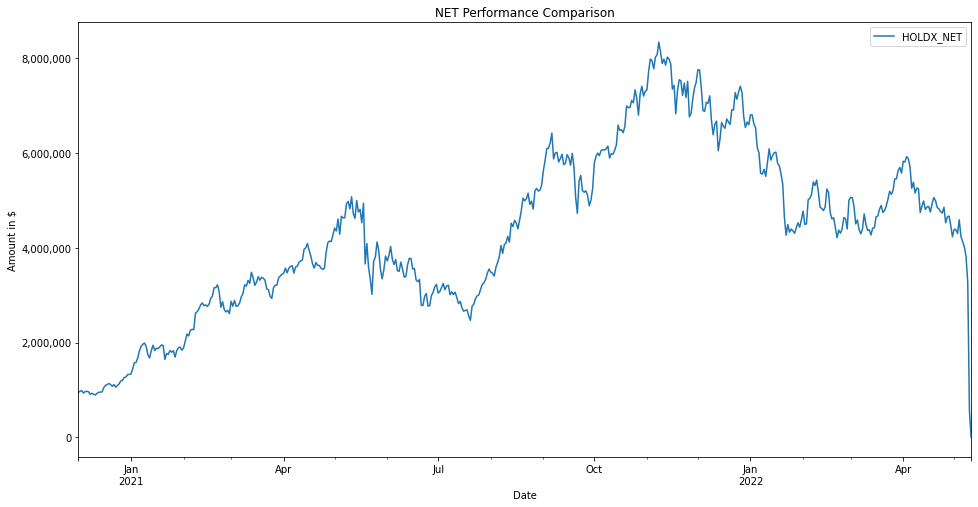

In [160]:
pl = hodlx_portfolio_df.plot(y=['HOLDX_NET'],figsize=(16,8),title='NET Performance Comparison')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [151]:
principal_usd = 100000
psg_staking_coins = ['ETH','SOL','AVAX','NEAR','FTM']
psg_staking_coins_allocations = [0.50,0.15,0.15,0.10,0.10]
psg_staking_coins_yields=[8.00,5.75,9.39,10.00,14.19]

psg_staking_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'], avax_df['Close'], near_df['Close'],ftm_df['Close']],axis=1)
psg_staking_portfolio_df.columns = psg_staking_coins

for i in range(0,len(psg_staking_coins)):
    calculate_allocation(i,psg_staking_coins[i],psg_staking_portfolio_df)
    
psg_staking_portfolio_df.fillna(0,inplace=True)
psg_staking_portfolio_df['NET'] = psg_staking_portfolio_df['ETH_NET']  + psg_staking_portfolio_df['SOL_NET'] + psg_staking_portfolio_df['AVAX_NET'] + psg_staking_portfolio_df['NEAR_NET'] + psg_staking_portfolio_df['FTM_NET']

psg_staking_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_ALLOC,ETH_NET_ALLOC_USD,ETH_INIT_AMNT,ETH_AMNT,ETH_NET,...,NEAR_NET_ALLOC_USD,NEAR_INIT_AMNT,NEAR_AMNT,NEAR_NET,FTM_ALLOC,FTM_NET_ALLOC_USD,FTM_INIT_AMNT,FTM_AMNT,FTM_NET,NET
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,0.5824,582400.0,987.43,987.43,582400.50,...,24500.0,22779.35,22779.35,24500.00,0.0214,21400.0,1041911.88,1041911.88,21400.00,952100.48
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,0.5824,582400.0,987.43,987.43,590835.90,...,24500.0,22779.35,22779.35,26796.54,0.0214,21400.0,1041911.88,1041911.88,23595.58,986126.04
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,0.5824,582400.0,987.43,987.43,609150.36,...,24500.0,22779.35,22779.35,26316.68,0.0214,21400.0,1041911.88,1041911.88,23847.65,1003233.52
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,0.5824,582400.0,987.43,987.43,564788.57,...,24500.0,22779.35,22779.35,25212.81,0.0214,21400.0,1041911.88,1041911.88,21924.17,918567.49
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,0.5824,582400.0,987.43,987.43,588062.46,...,24500.0,22779.35,22779.35,25313.80,0.0214,21400.0,1041911.88,1041911.88,23440.02,961319.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,0.5824,582400.0,987.43,987.43,2665888.40,...,24500.0,22779.35,22779.35,246057.98,0.0214,21400.0,1041911.88,1041911.88,756495.50,15885650.71
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,0.5824,582400.0,987.43,987.43,2611679.08,...,24500.0,22779.35,22779.35,238540.80,0.0214,21400.0,1041911.88,1041911.88,714472.34,15363405.02
2022-05-08,2513.908346,74.977144,51.193573,11.126441,0.672103,0.5824,582400.0,987.43,987.43,2482308.52,...,24500.0,22779.35,22779.35,253453.08,0.0214,21400.0,1041911.88,1041911.88,700272.56,14598928.81


In [153]:

# basket_staking_portfolio_df['basket_staking_nav'] = basket_staking_portfolio_df['ETH_NET_YIELD'] + basket_staking_portfolio_df['SOL_NET_YIELD'] + basket_staking_portfolio_df['AVAX_NET_YIELD']  + basket_staking_portfolio_df['NEAR_NET_YIELD'] + basket_staking_portfolio_df['FTM_NET_YIELD']
# basket_staking_portfolio_df

In [157]:

for i in range(0,len(psg_staking_coins)):
    calculate_yield(psg_staking_coins_yields[i],psg_staking_portfolio_df,psg_staking_coins[i])
    
psg_staking_portfolio_df['NET_YIELD'] = psg_staking_portfolio_df['ETH_NET_YIELD']  + psg_staking_portfolio_df['SOL_NET_YIELD'] + psg_staking_portfolio_df['AVAX_NET_YIELD'] + psg_staking_portfolio_df['NEAR_NET_YIELD'] + psg_staking_portfolio_df['FTM_NET_YIELD']

psg_staking_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_ALLOC,ETH_NET_ALLOC_USD,ETH_INIT_AMNT,ETH_AMNT,ETH_NET,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,NET_YIELD
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,0.5824,582400.0,987.43,987.43,582400.50,...,0.000246,13201.345660,47211.59,0.000261,22785.299007,24506.40,0.000364,1.042291e+06,21407.78,952291.45
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,0.5824,582400.0,987.43,987.43,590835.90,...,0.000246,13204.592117,49462.09,0.000261,22791.249567,26810.54,0.000364,1.042670e+06,23612.75,986521.26
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,0.5824,582400.0,987.43,987.43,609150.36,...,0.000246,13207.839374,50446.97,0.000261,22797.201681,26337.30,0.000364,1.043049e+06,23873.67,1003837.69
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,0.5824,582400.0,987.43,987.43,564788.57,...,0.000246,13211.087428,46991.39,0.000261,22803.155350,25239.16,0.000364,1.043428e+06,21956.07,919307.65
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,0.5824,582400.0,987.43,987.43,588062.46,...,0.000246,13214.336282,47972.43,0.000261,22809.110574,25346.87,0.000364,1.043808e+06,23482.66,962285.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,0.5824,582400.0,987.43,987.43,2665888.40,...,0.000246,15005.647977,856457.86,0.000261,26105.892030,281990.62,0.000364,1.259642e+06,914581.45,17447258.04
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,0.5824,582400.0,987.43,987.43,2611679.08,...,0.000246,15009.338146,830472.68,0.000261,26112.709789,273447.07,0.000364,1.260100e+06,864090.72,16875794.27
2022-05-08,2513.908346,74.977144,51.193573,11.126441,0.672103,0.5824,582400.0,987.43,987.43,2482308.52,...,0.000246,15013.029223,768570.60,0.000261,26119.529329,290617.39,0.000364,1.260558e+06,847225.30,16042372.24


In [104]:
psg_staking_portfolio_bear_df = psg_staking_portfolio_df[(psg_staking_portfolio_df.index >= datetime(2021,5,1)) & (psg_staking_portfolio_df.index <= datetime(2021,9,1))]
psg_staking_portfolio_bear_df


,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,Day_Count,Day_Count_Cum
Date,,,,,,,,,,,,,,,,,
2021-05-01,2953.032414,49.849501,31.850880,5.489976,0.801337,987.43,2915912.80,139872.45,6972571.88,13198.1,420371.10,22779.35,125058.07,1041911.88,834922.53,1,152
2021-05-02,2957.500000,46.960000,31.320000,5.290000,0.756280,987.43,2920324.22,139872.45,6568410.25,13198.1,413364.49,22779.35,120502.76,1041911.88,787976.89,1,153
2021-05-03,3440.551612,46.166985,36.189431,5.480264,0.712811,987.43,3397303.88,139872.45,6457489.27,13198.1,477631.73,22779.35,124836.86,1041911.88,742686.32,1,154
2021-05-04,3242.717709,42.768410,30.502789,4.830220,0.657704,987.43,3201956.75,139872.45,5982122.29,13198.1,402578.87,22779.35,110029.27,1041911.88,685269.12,1,155
2021-05-05,3527.600000,44.930000,35.330000,5.240000,0.784828,987.43,3483258.07,139872.45,6284469.18,13198.1,466288.87,22779.35,119363.79,1041911.88,817721.71,1,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-28,3247.422100,97.236800,50.264100,5.703414,0.522065,987.43,3206602.00,139872.45,13600749.45,13198.1,663390.62,22779.35,129920.06,1041911.88,543946.18,1,271
2021-08-29,3236.184200,94.301600,47.577600,5.642955,0.580409,987.43,3195505.36,139872.45,13190195.83,13198.1,627933.92,22779.35,128542.84,1041911.88,604734.74,1,272
2021-08-30,3233.098700,109.869300,41.354800,5.358814,0.793622,987.43,3192458.65,139872.45,15367688.17,13198.1,545804.79,22779.35,122070.31,1041911.88,826883.94,1,273


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


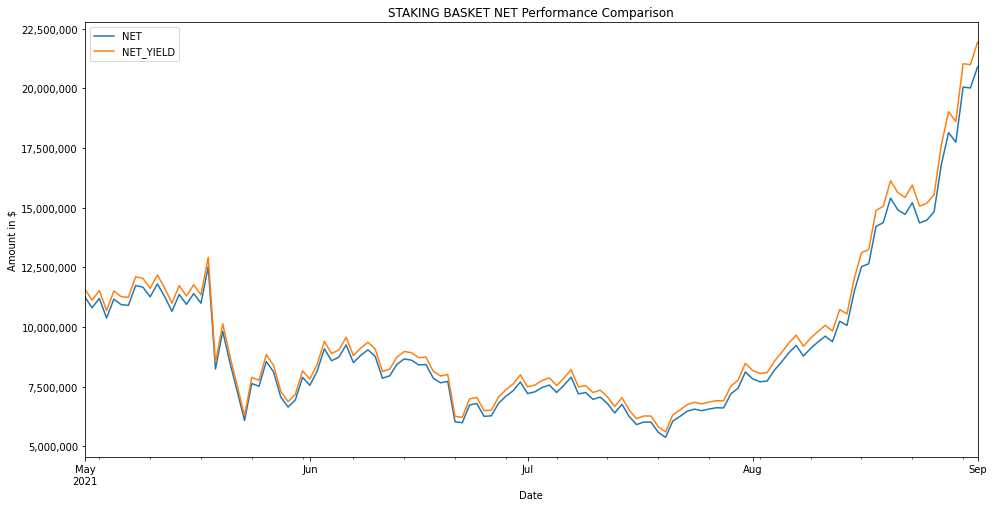

In [158]:
psg_staking_portfolio_bear_df = psg_staking_portfolio_df[(psg_staking_portfolio_df.index >= datetime(2021,5,1)) & (psg_staking_portfolio_df.index <= datetime(2021,9,1))]

pl = psg_staking_portfolio_bear_df.plot(y=['NET','NET_YIELD'],figsize=(16,8),title='STAKING BASKET NET Performance Comparison')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);




/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


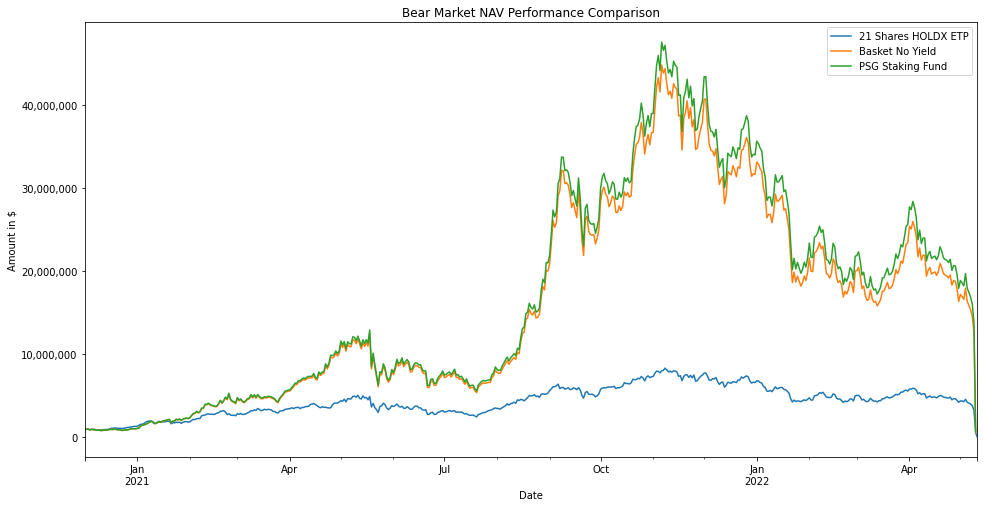

In [164]:
pl = compare_df.plot(y=['21 Shares HOLDX ETP','Basket No Yield','PSG Staking Fund'],figsize=(16,8),title='Bear Market NAV Performance Comparison')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


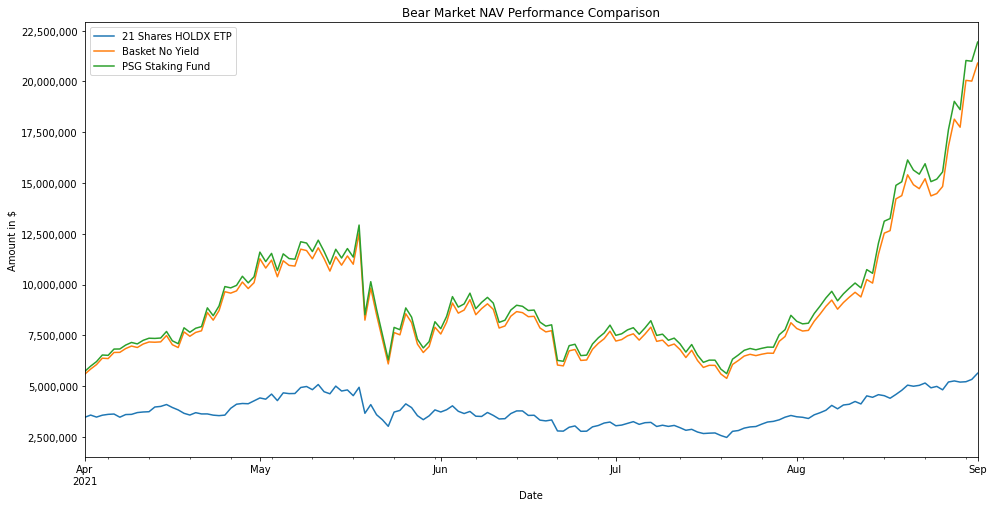

In [165]:
compare_df = pd.DataFrame(columns =['Date','21 Shares HOLDX ETP','Basket No Yield','PSG Staking Fund'])

compare_df.set_index('Date',inplace=True)
compare_df['21 Shares HOLDX ETP'] = hodlx_portfolio_df['HOLDX_NET']
compare_df['Basket No Yield'] = psg_staking_portfolio_df['NET']
compare_df['PSG Staking Fund'] =  psg_staking_portfolio_df['NET_YIELD']

compare_bear_df = compare_df[(compare_df.index >= datetime(2021,4,1)) & (compare_df.index <= datetime(2021,9,1))]

pl = compare_bear_df.plot(y=['21 Shares HOLDX ETP','Basket No Yield','PSG Staking Fund'],figsize=(16,8),title='Bear Market NAV Performance Comparison')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

NameError: name 'calculate_allocation' is not defined